In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from matplotlib import pyplot as plt 
from tqdm import tqdm

In [2]:
data=np.load(r'/Volumes/KINGSTON/Synthetic_data_no_defect/2025_11_18_sample_100x100x5mm_no_defect_isotropic_gaussian_heat_no_conv_cond_5.npz',allow_pickle=True)

In [3]:
data['meta']

array([['time', '18/11/2025 21:36:12'],
       ['lamp_power', '200'],
       ['lamp_power_units', 'W'],
       ['T1', '4'],
       ['T1_units', 'frames'],
       ['T2', '30'],
       ['T2_units', 'frames'],
       ['T3', '300'],
       ['T3_units', 'frames'],
       ['fps', '30.0'],
       ['fps_units', 'frames/s'],
       ['height', '512'],
       ['height_units', 'pixels'],
       ['width', '512'],
       ['width_units', 'pixels'],
       ['sequence_length', '334'],
       ['sequence_length_units', 'frames'],
       ['working_distance', '200.0'],
       ['working_distance_units', 'mm'],
       ['thickness', '0.005'],
       ['thickness_units', 'm'],
       ['size_X', '0.1'],
       ['size_X_units', 'm'],
       ['size_Y', '0.1'],
       ['size_Y_units', 'm'],
       ['thermal_conductivity', '5.0'],
       ['thermal_conductivity_units', 'W/(m·K)'],
       ['density', '1600.0'],
       ['density_units', 'kg/m^3'],
       ['specific_heat', '700.0'],
       ['specific_heat_units', 'J/(kg

In [4]:
temp=data['data']
temp=(temp-temp.min())/(temp.max()-temp.min())
print(f"Temp min: {temp.min()} | Temp max: {temp.max()}")

Temp min: 0.0 | Temp max: 1.0


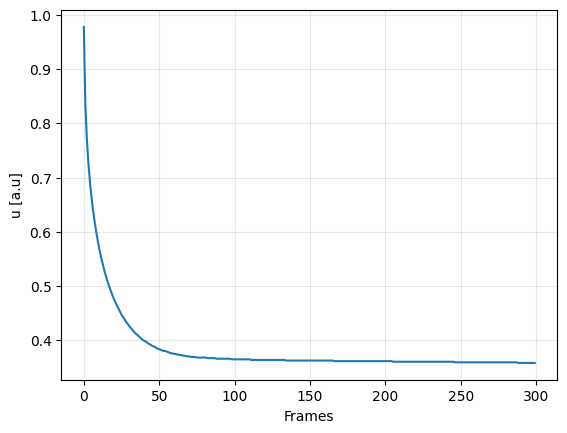

In [5]:
T,Y,X=temp.shape
y_center=Y//2
x_center=X//2
u_np=temp[34:,y_center,x_center]
plt.plot(u_np)
plt.xlabel('Frames')
plt.ylabel('u [a.u]')
plt.grid(alpha=0.3)

In [6]:
print(f"Temp min: {u_np.min()} | Temp max: {u_np.max()}")

Temp min: 0.35792951541850226 | Temp max: 0.9779735682819384


In [7]:
class FCN(nn.Module):
    "Defines a fully-connected network in PyTorch"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

        a_phys=1e-6
        # Defining our diffusivity via logarithmic mapping
        self.a = nn.Parameter(
    torch.log(torch.tensor(a_phys, dtype=torch.float32))
)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [8]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(2,1,32,3)

u=torch.from_numpy(u_np).to(torch.float32).view(-1,1)

In [9]:
t=torch.linspace(0,10,300).view(-1,1)
x_boundary=torch.zeros_like(u)

x_data=torch.hstack([t,x_boundary])
x_boundary_back=torch.tensor([0.0,0.1,10.0,0.1]).view(-1,2)
X=torch.concatenate([x_data,x_boundary_back],dim=0)

In [10]:
X.size()

torch.Size([302, 2])

In [11]:
u_back=torch.tensor([0.0,u[-1]]).view(-1,1)
u_back
Y=torch.vstack([u,u_back])

In [12]:
# Collocation points
res=100 # Resolution parameter to our solution
time_res=300
z_coll=torch.linspace(0,0.005,res)
t_coll=torch.linspace(0,10,time_res)

# Torch meshgrid only accept 1d tensors as input
T_mesh, X_mesh = torch.meshgrid(t_coll, z_coll, indexing='ij')
X_coll = torch.stack([T_mesh.reshape(-1), X_mesh.reshape(-1)], dim=1)
X_coll.size()


torch.Size([30000, 2])

In [13]:
X=X.requires_grad_(True)
Y=Y.requires_grad_(True)
X_coll=X_coll.requires_grad_(True)
flux_at_boundary=torch.zeros_like(Y).requires_grad_(True)

In [ ]:
n_epoch=15001



optimiser=optim.Adam(pinn.parameters(),lr=1e-3)
for i in tqdm(range(n_epoch)):
  optimiser.zero_grad()
    
  # compute each term of the PINN loss function above
  # using the following hyperparameters
  lambda1, lambda2 = 1e-1, 1e-4

  # Calculate boundary loss data
  u_p=pinn(X)
  loss1=torch.mean(u_p**2)

  # Calculate Neuman boundary loss
  u_tx=torch.autograd.grad(u_p,X,torch.ones_like(u_p),create_graph=True)[0]
  u_t=u_tx[:,0].view(-1,1) # Time gradient
  u_x=u_tx[:,1].view(-1,1) # Space gradient
  loss2=torch.mean((u_x-flux_at_boundary)**2)

  # Calculate PDE loss
  u_coll=pinn(X_coll)
  u_coll_tx=torch.autograd.grad(u_coll,X_coll,torch.ones_like(u_coll),create_graph=True,retain_graph=True)[0]
  u_coll_t=u_coll_tx[:,0].view(-1,1) # Gradient in time
  u_coll_x=u_coll_tx[:,1].view(-1,1) # Gradient in space

  u_coll_txx=torch.autograd.grad(u_coll_x,X_coll,torch.ones_like(u_coll),create_graph=True)[0]
  u_coll_xx=u_coll_txx[:,1].view(-1,1)
    
  a_phys=torch.exp(pinn.a)
  f=u_coll_t-a_phys*u_coll_xx
  loss3=torch.mean(f**2)

  losses=loss1+lambda1*loss2+lambda2*loss3    

  losses.backward()
  optimiser.step()

  if i % 100 == 0:
    print(f"[{i}] "
          f"Total: {losses.item():.4e} | "
          f"Data: {loss1.item():.4e} | "
          f"Boundary: {loss2.item():.4e} | "
          f"PDE: {loss3.item():.4e}")




  0%|          | 6/15001 [00:00<09:10, 27.22it/s]

[0] Total: 3.7007e-02 | Data: 3.6985e-02 | Boundary: 2.1533e-04 | PDE: 5.4027e-04


  1%|          | 104/15001 [00:03<07:53, 31.47it/s]

[100] Total: 1.7869e-05 | Data: 1.6579e-05 | Boundary: 1.2850e-05 | PDE: 5.7954e-05


  1%|▏         | 204/15001 [00:06<07:48, 31.62it/s]

[200] Total: 7.6620e-06 | Data: 6.7090e-06 | Boundary: 9.5050e-06 | PDE: 2.4637e-05


  2%|▏         | 304/15001 [00:09<07:45, 31.60it/s]

[300] Total: 3.4600e-06 | Data: 2.7493e-06 | Boundary: 7.0955e-06 | PDE: 1.1587e-05


  3%|▎         | 404/15001 [00:12<07:40, 31.67it/s]

[400] Total: 1.4323e-06 | Data: 1.0003e-06 | Boundary: 4.3143e-06 | PDE: 5.3504e-06


  3%|▎         | 504/15001 [00:16<07:49, 30.86it/s]

[500] Total: 5.7671e-07 | Data: 3.5852e-07 | Boundary: 2.1793e-06 | PDE: 2.6663e-06


  4%|▍         | 604/15001 [00:19<07:44, 31.02it/s]

[600] Total: 2.5601e-07 | Data: 1.5339e-07 | Boundary: 1.0247e-06 | PDE: 1.5642e-06


  5%|▍         | 704/15001 [00:22<07:53, 30.21it/s]

[700] Total: 1.4576e-07 | Data: 9.0957e-08 | Boundary: 5.4689e-07 | PDE: 1.0971e-06


  5%|▌         | 804/15001 [00:26<08:11, 28.87it/s]

[800] Total: 1.0718e-07 | Data: 6.9426e-08 | Boundary: 3.7667e-07 | PDE: 8.7735e-07


  6%|▌         | 906/15001 [00:29<07:47, 30.12it/s]

[900] Total: 9.0225e-08 | Data: 5.9140e-08 | Boundary: 3.1010e-07 | PDE: 7.5733e-07


  7%|▋         | 1005/15001 [00:32<07:52, 29.64it/s]

[1000] Total: 7.9659e-08 | Data: 5.2387e-08 | Boundary: 2.7204e-07 | PDE: 6.8065e-07


  7%|▋         | 1107/15001 [00:36<07:45, 29.83it/s]

[1100] Total: 7.1527e-08 | Data: 4.7240e-08 | Boundary: 2.4224e-07 | PDE: 6.2493e-07


  8%|▊         | 1207/15001 [00:39<07:19, 31.36it/s]

[1200] Total: 6.4876e-08 | Data: 4.3156e-08 | Boundary: 2.1661e-07 | PDE: 5.8091e-07


  9%|▊         | 1306/15001 [00:42<07:39, 29.83it/s]

[1300] Total: 5.9405e-08 | Data: 3.9913e-08 | Boundary: 1.9438e-07 | PDE: 5.4462e-07


  9%|▉         | 1405/15001 [00:46<07:41, 29.47it/s]

[1400] Total: 5.4935e-08 | Data: 3.7371e-08 | Boundary: 1.7513e-07 | PDE: 5.1423e-07


 10%|█         | 1505/15001 [00:49<07:24, 30.33it/s]

[1500] Total: 5.1291e-08 | Data: 3.5400e-08 | Boundary: 1.5843e-07 | PDE: 4.8876e-07


 11%|█         | 1605/15001 [00:52<07:25, 30.09it/s]

[1600] Total: 4.8321e-08 | Data: 3.3891e-08 | Boundary: 1.4383e-07 | PDE: 4.6752e-07


 11%|█▏        | 1705/15001 [00:56<07:29, 29.58it/s]

[1700] Total: 4.5882e-08 | Data: 3.2743e-08 | Boundary: 1.3094e-07 | PDE: 4.4991e-07


 12%|█▏        | 1806/15001 [00:59<07:33, 29.10it/s]

[1800] Total: 4.3854e-08 | Data: 3.1867e-08 | Boundary: 1.1943e-07 | PDE: 4.3547e-07


 13%|█▎        | 1905/15001 [01:03<07:16, 30.03it/s]

[1900] Total: 4.2140e-08 | Data: 3.1194e-08 | Boundary: 1.0903e-07 | PDE: 4.2367e-07


 13%|█▎        | 2007/15001 [01:06<07:15, 29.86it/s]

[2000] Total: 4.0659e-08 | Data: 3.0662e-08 | Boundary: 9.9560e-08 | PDE: 4.1412e-07


 14%|█▍        | 2104/15001 [01:10<07:04, 30.41it/s]

[2100] Total: 3.9356e-08 | Data: 3.0228e-08 | Boundary: 9.0876e-08 | PDE: 4.0645e-07


 15%|█▍        | 2205/15001 [01:13<07:05, 30.09it/s]

[2200] Total: 3.8188e-08 | Data: 2.9859e-08 | Boundary: 8.2890e-08 | PDE: 4.0030e-07


 15%|█▌        | 2306/15001 [01:16<07:05, 29.84it/s]

[2300] Total: 3.7121e-08 | Data: 2.9528e-08 | Boundary: 7.5537e-08 | PDE: 3.9535e-07


 16%|█▌        | 2404/15001 [01:20<06:52, 30.51it/s]

[2400] Total: 3.6137e-08 | Data: 2.9220e-08 | Boundary: 6.8778e-08 | PDE: 3.9138e-07


 17%|█▋        | 2504/15001 [01:23<06:55, 30.05it/s]

[2500] Total: 3.5220e-08 | Data: 2.8922e-08 | Boundary: 6.2584e-08 | PDE: 3.8816e-07


 17%|█▋        | 2607/15001 [01:26<06:55, 29.80it/s]

[2600] Total: 3.4362e-08 | Data: 2.8629e-08 | Boundary: 5.6935e-08 | PDE: 3.8549e-07


 18%|█▊        | 2704/15001 [01:30<06:53, 29.72it/s]

[2700] Total: 3.3555e-08 | Data: 2.8336e-08 | Boundary: 5.1812e-08 | PDE: 3.8323e-07


 19%|█▊        | 2805/15001 [01:33<06:51, 29.61it/s]

[2800] Total: 3.2796e-08 | Data: 2.8038e-08 | Boundary: 4.7195e-08 | PDE: 3.8121e-07


 19%|█▉        | 2905/15001 [01:36<06:38, 30.33it/s]

[2900] Total: 3.2078e-08 | Data: 2.7734e-08 | Boundary: 4.3057e-08 | PDE: 3.7934e-07


 20%|██        | 3004/15001 [01:40<06:38, 30.14it/s]

[3000] Total: 3.1398e-08 | Data: 2.7423e-08 | Boundary: 3.9373e-08 | PDE: 3.7753e-07


 21%|██        | 3107/15001 [01:43<06:43, 29.48it/s]

[3100] Total: 3.0754e-08 | Data: 2.7105e-08 | Boundary: 3.6114e-08 | PDE: 3.7567e-07


 21%|██▏       | 3206/15001 [01:47<06:36, 29.78it/s]

[3200] Total: 3.0139e-08 | Data: 2.6777e-08 | Boundary: 3.3247e-08 | PDE: 3.7373e-07


 22%|██▏       | 3304/15001 [01:50<06:46, 28.75it/s]

[3300] Total: 2.9553e-08 | Data: 2.6442e-08 | Boundary: 3.0739e-08 | PDE: 3.7164e-07


 23%|██▎       | 3405/15001 [01:53<06:33, 29.45it/s]

[3400] Total: 2.8990e-08 | Data: 2.6098e-08 | Boundary: 2.8551e-08 | PDE: 3.6938e-07


 23%|██▎       | 3505/15001 [01:57<06:23, 29.95it/s]

[3500] Total: 2.8445e-08 | Data: 2.5743e-08 | Boundary: 2.6649e-08 | PDE: 3.6692e-07


 24%|██▍       | 3606/15001 [02:00<06:28, 29.34it/s]

[3600] Total: 2.7916e-08 | Data: 2.5379e-08 | Boundary: 2.4999e-08 | PDE: 3.6424e-07


 25%|██▍       | 3706/15001 [02:04<06:21, 29.59it/s]

[3700] Total: 2.7399e-08 | Data: 2.5006e-08 | Boundary: 2.3566e-08 | PDE: 3.6131e-07


 25%|██▌       | 3806/15001 [02:07<06:07, 30.50it/s]

[3800] Total: 2.6890e-08 | Data: 2.4622e-08 | Boundary: 2.2317e-08 | PDE: 3.5812e-07


 26%|██▌       | 3904/15001 [02:10<06:01, 30.67it/s]

[3900] Total: 2.6385e-08 | Data: 2.4227e-08 | Boundary: 2.1226e-08 | PDE: 3.5465e-07


 27%|██▋       | 4007/15001 [02:14<06:01, 30.44it/s]

[4000] Total: 2.5884e-08 | Data: 2.3822e-08 | Boundary: 2.0264e-08 | PDE: 3.5091e-07


 27%|██▋       | 4107/15001 [02:17<06:00, 30.18it/s]

[4100] Total: 2.5382e-08 | Data: 2.3407e-08 | Boundary: 1.9407e-08 | PDE: 3.4690e-07


 28%|██▊       | 4205/15001 [02:20<05:50, 30.77it/s]

[4200] Total: 2.4878e-08 | Data: 2.2980e-08 | Boundary: 1.8636e-08 | PDE: 3.4260e-07


 29%|██▊       | 4303/15001 [02:24<05:50, 30.50it/s]

[4300] Total: 2.4369e-08 | Data: 2.2542e-08 | Boundary: 1.7933e-08 | PDE: 3.3801e-07


 29%|██▉       | 4406/15001 [02:27<05:52, 30.06it/s]

[4400] Total: 2.3856e-08 | Data: 2.2094e-08 | Boundary: 1.7284e-08 | PDE: 3.3314e-07


 30%|███       | 4507/15001 [02:30<05:54, 29.60it/s]

[4500] Total: 2.3334e-08 | Data: 2.1633e-08 | Boundary: 1.6676e-08 | PDE: 3.2797e-07


 31%|███       | 4605/15001 [02:34<05:34, 31.09it/s]

[4600] Total: 1.5898e-07 | Data: 1.5479e-07 | Boundary: 4.1380e-08 | PDE: 4.8149e-07


 31%|███▏      | 4706/15001 [02:37<05:45, 29.78it/s]

[4700] Total: 2.0748e-08 | Data: 1.9027e-08 | Boundary: 1.6871e-08 | PDE: 3.3483e-07


 32%|███▏      | 4804/15001 [02:40<05:42, 29.77it/s]

[4800] Total: 1.9949e-08 | Data: 1.8322e-08 | Boundary: 1.5955e-08 | PDE: 3.1040e-07


 33%|███▎      | 4906/15001 [02:44<05:38, 29.78it/s]

[4900] Total: 1.9479e-08 | Data: 1.7917e-08 | Boundary: 1.5325e-08 | PDE: 2.9856e-07


 33%|███▎      | 5004/15001 [02:47<05:41, 29.29it/s]

[5000] Total: 1.9046e-08 | Data: 1.7538e-08 | Boundary: 1.4788e-08 | PDE: 2.9097e-07


 34%|███▍      | 5104/15001 [02:50<05:34, 29.57it/s]

[5100] Total: 1.8612e-08 | Data: 1.7154e-08 | Boundary: 1.4297e-08 | PDE: 2.8464e-07


 35%|███▍      | 5205/15001 [02:54<05:25, 30.09it/s]

[5200] Total: 1.9737e-08 | Data: 1.8102e-08 | Boundary: 1.6028e-08 | PDE: 3.1832e-07


 35%|███▌      | 5304/15001 [02:57<05:23, 30.01it/s]

[5300] Total: 1.7163e-08 | Data: 1.5733e-08 | Boundary: 1.4004e-08 | PDE: 2.8818e-07


 36%|███▌      | 5404/15001 [03:01<05:21, 29.83it/s]

[5400] Total: 1.6695e-08 | Data: 1.5324e-08 | Boundary: 1.3441e-08 | PDE: 2.7331e-07


 37%|███▋      | 5504/15001 [03:04<05:14, 30.24it/s]

[5500] Total: 1.6292e-08 | Data: 1.4964e-08 | Boundary: 1.3017e-08 | PDE: 2.6484e-07


 37%|███▋      | 5607/15001 [03:07<05:14, 29.89it/s]

[5600] Total: 9.1497e-06 | Data: 9.1438e-06 | Boundary: 5.7399e-08 | PDE: 1.3925e-06


 38%|███▊      | 5705/15001 [03:11<05:04, 30.56it/s]

[5700] Total: 1.6237e-08 | Data: 1.4714e-08 | Boundary: 1.4918e-08 | PDE: 3.1309e-07


 39%|███▊      | 5804/15001 [03:14<05:13, 29.37it/s]

[5800] Total: 1.4777e-08 | Data: 1.3428e-08 | Boundary: 1.3218e-08 | PDE: 2.7422e-07


 39%|███▉      | 5907/15001 [03:17<05:01, 30.13it/s]

[5900] Total: 1.4367e-08 | Data: 1.3076e-08 | Boundary: 1.2653e-08 | PDE: 2.5943e-07


 40%|████      | 6006/15001 [03:21<05:01, 29.86it/s]

[6000] Total: 1.4012e-08 | Data: 1.2761e-08 | Boundary: 1.2265e-08 | PDE: 2.5062e-07


 41%|████      | 6103/15001 [03:24<04:52, 30.46it/s]

[6100] Total: 1.3656e-08 | Data: 1.2440e-08 | Boundary: 1.1917e-08 | PDE: 2.4325e-07


 41%|████▏     | 6203/15001 [03:27<04:54, 29.87it/s]

[6200] Total: 1.3294e-08 | Data: 1.2112e-08 | Boundary: 1.1581e-08 | PDE: 2.3621e-07


 42%|████▏     | 6306/15001 [03:31<04:53, 29.63it/s]

[6300] Total: 1.2928e-08 | Data: 1.1779e-08 | Boundary: 1.1253e-08 | PDE: 2.2920e-07


 43%|████▎     | 6405/15001 [03:34<04:45, 30.16it/s]

[6400] Total: 3.7134e-07 | Data: 3.6734e-07 | Boundary: 3.9676e-08 | PDE: 3.2692e-07


 43%|████▎     | 6504/15001 [03:37<04:40, 30.30it/s]

[6500] Total: 1.2528e-08 | Data: 1.1225e-08 | Boundary: 1.2775e-08 | PDE: 2.5763e-07


 44%|████▍     | 6606/15001 [03:41<04:43, 29.59it/s]

[6600] Total: 1.1935e-08 | Data: 1.0744e-08 | Boundary: 1.1677e-08 | PDE: 2.3404e-07


 45%|████▍     | 6705/15001 [03:44<04:40, 29.59it/s]

[6700] Total: 1.1579e-08 | Data: 1.0438e-08 | Boundary: 1.1185e-08 | PDE: 2.2368e-07


 45%|████▌     | 6806/15001 [03:48<04:35, 29.74it/s]

[6800] Total: 1.1233e-08 | Data: 1.0131e-08 | Boundary: 1.0800e-08 | PDE: 2.1564e-07


 46%|████▌     | 6906/15001 [03:51<04:30, 29.91it/s]

[6900] Total: 1.0887e-08 | Data: 9.8212e-09 | Boundary: 1.0452e-08 | PDE: 2.0806e-07


 47%|████▋     | 7005/15001 [03:54<04:24, 30.27it/s]

[7000] Total: 1.0542e-08 | Data: 9.5093e-09 | Boundary: 1.0125e-08 | PDE: 2.0060e-07


 47%|████▋     | 7106/15001 [03:58<04:29, 29.32it/s]

[7100] Total: 1.0196e-08 | Data: 9.1952e-09 | Boundary: 9.8129e-09 | PDE: 1.9323e-07


 48%|████▊     | 7204/15001 [04:01<04:19, 30.05it/s]

[7200] Total: 1.8605e-08 | Data: 1.7172e-08 | Boundary: 1.4073e-08 | PDE: 2.5924e-07


 49%|████▊     | 7305/15001 [04:05<04:19, 29.68it/s]

[7300] Total: 9.5374e-09 | Data: 8.5602e-09 | Boundary: 9.5712e-09 | PDE: 2.0037e-07


 49%|████▉     | 7404/15001 [04:08<04:18, 29.42it/s]

[7400] Total: 9.1930e-09 | Data: 8.2579e-09 | Boundary: 9.1635e-09 | PDE: 1.8815e-07


 50%|█████     | 7506/15001 [04:11<04:11, 29.85it/s]

[7500] Total: 8.8729e-09 | Data: 7.9683e-09 | Boundary: 8.8655e-09 | PDE: 1.8023e-07


 51%|█████     | 7606/15001 [04:15<04:13, 29.18it/s]

[7600] Total: 8.5547e-09 | Data: 7.6789e-09 | Boundary: 8.5853e-09 | PDE: 1.7285e-07


 51%|█████▏    | 7706/15001 [04:18<04:05, 29.72it/s]

[7700] Total: 8.2384e-09 | Data: 7.3905e-09 | Boundary: 8.3137e-09 | PDE: 1.6568e-07


 52%|█████▏    | 7804/15001 [04:21<03:58, 30.16it/s]

[7800] Total: 7.9233e-09 | Data: 7.1026e-09 | Boundary: 8.0482e-09 | PDE: 1.5867e-07


 53%|█████▎    | 7904/15001 [04:25<03:55, 30.11it/s]

[7900] Total: 1.1893e-07 | Data: 1.1747e-07 | Boundary: 1.4364e-08 | PDE: 2.6644e-07


 53%|█████▎    | 8005/15001 [04:28<03:59, 29.15it/s]

[8000] Total: 7.2736e-09 | Data: 6.5579e-09 | Boundary: 6.9925e-09 | PDE: 1.6454e-07


 54%|█████▍    | 8106/15001 [04:32<03:49, 30.00it/s]

[8100] Total: 6.9707e-09 | Data: 6.2842e-09 | Boundary: 6.7125e-09 | PDE: 1.5341e-07


 55%|█████▍    | 8207/15001 [04:35<03:42, 30.48it/s]

[8200] Total: 6.6932e-09 | Data: 6.0273e-09 | Boundary: 6.5124e-09 | PDE: 1.4629e-07


 55%|█████▌    | 8305/15001 [04:38<03:41, 30.25it/s]

[8300] Total: 6.4209e-09 | Data: 5.7748e-09 | Boundary: 6.3209e-09 | PDE: 1.3957e-07


 56%|█████▌    | 8405/15001 [04:42<03:40, 29.90it/s]

[8400] Total: 6.1527e-09 | Data: 5.5259e-09 | Boundary: 6.1342e-09 | PDE: 1.3309e-07


 57%|█████▋    | 8505/15001 [04:45<03:35, 30.11it/s]

[8500] Total: 5.8886e-09 | Data: 5.2808e-09 | Boundary: 5.9519e-09 | PDE: 1.2684e-07


 57%|█████▋    | 8606/15001 [04:48<03:36, 29.49it/s]

[8600] Total: 5.6281e-09 | Data: 5.0387e-09 | Boundary: 5.7732e-09 | PDE: 1.2082e-07


 58%|█████▊    | 8707/15001 [04:52<03:30, 29.87it/s]

[8700] Total: 1.0657e-05 | Data: 1.0656e-05 | Boundary: 1.1473e-08 | PDE: 1.4480e-07


 59%|█████▊    | 8805/15001 [04:55<03:21, 30.69it/s]

[8800] Total: 6.3043e-09 | Data: 5.7781e-09 | Boundary: 5.1330e-09 | PDE: 1.2962e-07


 59%|█████▉    | 8906/15001 [04:58<03:22, 30.16it/s]

[8900] Total: 5.3959e-09 | Data: 4.8920e-09 | Boundary: 4.9201e-09 | PDE: 1.1937e-07


 60%|██████    | 9006/15001 [05:02<03:20, 29.95it/s]

[9000] Total: 5.1393e-09 | Data: 4.6518e-09 | Boundary: 4.7617e-09 | PDE: 1.1346e-07


 61%|██████    | 9105/15001 [05:05<03:16, 30.06it/s]

[9100] Total: 4.8870e-09 | Data: 4.4148e-09 | Boundary: 4.6144e-09 | PDE: 1.0780e-07


 61%|██████▏   | 9205/15001 [05:08<03:15, 29.58it/s]

[9200] Total: 4.6391e-09 | Data: 4.1816e-09 | Boundary: 4.4729e-09 | PDE: 1.0233e-07


 62%|██████▏   | 9305/15001 [05:12<03:15, 29.16it/s]

[9300] Total: 6.0968e-09 | Data: 5.6492e-09 | Boundary: 4.3619e-09 | PDE: 1.1426e-07


 63%|██████▎   | 9405/15001 [05:15<03:09, 29.60it/s]

[9400] Total: 4.5728e-09 | Data: 4.1574e-09 | Boundary: 4.0528e-09 | PDE: 1.0072e-07


 63%|██████▎   | 9506/15001 [05:19<03:09, 29.01it/s]

[9500] Total: 4.3329e-09 | Data: 3.9333e-09 | Boundary: 3.9000e-09 | PDE: 9.5900e-08


 64%|██████▍   | 9605/15001 [05:22<03:01, 29.70it/s]

[9600] Total: 4.0976e-09 | Data: 3.7119e-09 | Boundary: 3.7653e-09 | PDE: 9.1150e-08


 65%|██████▍   | 9706/15001 [05:25<02:59, 29.48it/s]

[9700] Total: 3.8664e-09 | Data: 3.4934e-09 | Boundary: 3.6434e-09 | PDE: 8.6510e-08


 65%|██████▌   | 9804/15001 [05:29<02:51, 30.22it/s]

[9800] Total: 1.1471e-08 | Data: 1.1080e-08 | Boundary: 3.8090e-09 | PDE: 1.0118e-07


 66%|██████▌   | 9904/15001 [05:32<02:52, 29.56it/s]

[9900] Total: 3.9777e-09 | Data: 3.6259e-09 | Boundary: 3.4294e-09 | PDE: 8.8254e-08


 67%|██████▋   | 10004/15001 [05:36<02:51, 29.13it/s]

[10000] Total: 3.7419e-09 | Data: 3.4036e-09 | Boundary: 3.2991e-09 | PDE: 8.3701e-08


 67%|██████▋   | 10105/15001 [05:39<02:47, 29.18it/s]

[10100] Total: 3.5122e-09 | Data: 3.1854e-09 | Boundary: 3.1887e-09 | PDE: 7.9254e-08


 68%|██████▊   | 10207/15001 [05:42<02:40, 29.81it/s]

[10200] Total: 1.3503e-07 | Data: 1.2102e-07 | Boundary: 1.3991e-07 | PDE: 1.7748e-07


 69%|██████▊   | 10306/15001 [05:46<02:34, 30.31it/s]

[10300] Total: 3.7296e-09 | Data: 3.4091e-09 | Boundary: 3.1213e-09 | PDE: 8.3960e-08


 69%|██████▉   | 10406/15001 [05:49<02:37, 29.24it/s]

[10400] Total: 3.5041e-09 | Data: 3.1917e-09 | Boundary: 3.0447e-09 | PDE: 7.9629e-08


 70%|███████   | 10505/15001 [05:53<02:33, 29.22it/s]

[10500] Total: 3.2933e-09 | Data: 2.9880e-09 | Boundary: 2.9783e-09 | PDE: 7.5235e-08


 71%|███████   | 10605/15001 [05:56<02:26, 29.91it/s]

[10600] Total: 9.1804e-09 | Data: 8.8526e-09 | Boundary: 3.1976e-09 | PDE: 8.0876e-08


 71%|███████▏  | 10706/15001 [05:59<02:21, 30.30it/s]

[10700] Total: 3.2172e-09 | Data: 2.9116e-09 | Boundary: 2.9836e-09 | PDE: 7.3191e-08


 72%|███████▏  | 10805/15001 [06:03<02:19, 30.16it/s]

[10800] Total: 3.0136e-09 | Data: 2.7171e-09 | Boundary: 2.8965e-09 | PDE: 6.9059e-08


 73%|███████▎  | 10904/15001 [06:06<02:21, 28.98it/s]

[10900] Total: 1.6380e-06 | Data: 1.6310e-06 | Boundary: 7.0472e-08 | PDE: 2.5822e-07


 73%|███████▎  | 11006/15001 [06:09<02:12, 30.25it/s]

[11000] Total: 3.1832e-09 | Data: 2.8877e-09 | Boundary: 2.8855e-09 | PDE: 6.9546e-08


 74%|███████▍  | 11104/15001 [06:13<02:15, 28.82it/s]

[11100] Total: 2.8341e-09 | Data: 2.5492e-09 | Boundary: 2.7840e-09 | PDE: 6.5366e-08


 75%|███████▍  | 11206/15001 [06:16<02:07, 29.75it/s]

[11200] Total: 2.6349e-09 | Data: 2.3582e-09 | Boundary: 2.7057e-09 | PDE: 6.1303e-08


 75%|███████▌  | 11306/15001 [06:20<02:04, 29.64it/s]

[11300] Total: 5.7745e-09 | Data: 5.4839e-09 | Boundary: 2.8377e-09 | PDE: 6.7986e-08


 76%|███████▌  | 11405/15001 [06:23<02:01, 29.70it/s]

[11400] Total: 2.6353e-09 | Data: 2.3602e-09 | Boundary: 2.6901e-09 | PDE: 6.1425e-08


 77%|███████▋  | 11507/15001 [06:26<01:55, 30.26it/s]

[11500] Total: 2.4419e-09 | Data: 2.1742e-09 | Boundary: 2.6197e-09 | PDE: 5.7340e-08


 77%|███████▋  | 11606/15001 [06:30<01:54, 29.63it/s]

[11600] Total: 3.6443e-07 | Data: 3.6267e-07 | Boundary: 1.7498e-08 | PDE: 1.6216e-07


 78%|███████▊  | 11706/15001 [06:33<01:49, 29.95it/s]

[11700] Total: 2.5238e-09 | Data: 2.2561e-09 | Boundary: 2.6169e-09 | PDE: 6.0446e-08


 79%|███████▊  | 11805/15001 [06:37<01:47, 29.81it/s]

[11800] Total: 2.3372e-09 | Data: 2.0727e-09 | Boundary: 2.5892e-09 | PDE: 5.6308e-08


 79%|███████▉  | 11904/15001 [06:40<01:43, 29.93it/s]

[11900] Total: 7.4442e-08 | Data: 7.4122e-08 | Boundary: 3.1484e-09 | PDE: 4.9949e-08


 80%|████████  | 12007/15001 [06:43<01:38, 30.46it/s]

[12000] Total: 2.5005e-09 | Data: 2.2402e-09 | Boundary: 2.5449e-09 | PDE: 5.7620e-08


 81%|████████  | 12105/15001 [06:47<01:41, 28.56it/s]

[12100] Total: 2.1808e-09 | Data: 1.9277e-09 | Boundary: 2.4778e-09 | PDE: 5.3379e-08


 81%|████████▏ | 12206/15001 [06:51<01:43, 26.97it/s]

[12200] Total: 2.0146e-09 | Data: 1.7647e-09 | Boundary: 2.4500e-09 | PDE: 4.9312e-08


 82%|████████▏ | 12304/15001 [06:54<01:34, 28.68it/s]

[12300] Total: 3.9815e-08 | Data: 3.8787e-08 | Boundary: 1.0209e-08 | PDE: 7.3606e-08


 83%|████████▎ | 12406/15001 [06:58<01:31, 28.45it/s]

[12400] Total: 1.9743e-09 | Data: 1.7321e-09 | Boundary: 2.3722e-09 | PDE: 4.9679e-08


 83%|████████▎ | 12505/15001 [07:01<01:29, 28.03it/s]

[12500] Total: 1.8134e-09 | Data: 1.5757e-09 | Boundary: 2.3315e-09 | PDE: 4.5437e-08


 84%|████████▍ | 12605/15001 [07:05<01:24, 28.29it/s]

[12600] Total: 1.6704e-09 | Data: 1.4354e-09 | Boundary: 2.3087e-09 | PDE: 4.1722e-08


 85%|████████▍ | 12706/15001 [07:08<01:16, 29.86it/s]

[12700] Total: 1.5383e-09 | Data: 1.3057e-09 | Boundary: 2.2875e-09 | PDE: 3.8390e-08


 85%|████████▌ | 12806/15001 [07:12<01:13, 29.90it/s]

[12800] Total: 6.2223e-06 | Data: 6.2200e-06 | Boundary: 2.3368e-08 | PDE: 5.5381e-08


 86%|████████▌ | 12904/15001 [07:16<01:18, 26.77it/s]

[12900] Total: 1.8076e-09 | Data: 1.5833e-09 | Boundary: 2.1982e-09 | PDE: 4.4611e-08


 87%|████████▋ | 13004/15001 [07:19<01:07, 29.46it/s]

[13000] Total: 1.5826e-09 | Data: 1.3592e-09 | Boundary: 2.1932e-09 | PDE: 4.0418e-08


 87%|████████▋ | 13103/15001 [07:22<01:02, 30.25it/s]

[13100] Total: 1.0111e-06 | Data: 1.0108e-06 | Boundary: 3.1578e-09 | PDE: 3.6245e-08


 88%|████████▊ | 13206/15001 [07:26<01:00, 29.59it/s]

[13200] Total: 1.1602e-08 | Data: 1.1312e-08 | Boundary: 2.8440e-09 | PDE: 5.3013e-08


 89%|████████▊ | 13305/15001 [07:29<00:57, 29.37it/s]

[13300] Total: 1.5299e-09 | Data: 1.3032e-09 | Boundary: 2.2244e-09 | PDE: 4.2278e-08


 89%|████████▉ | 13404/15001 [07:33<00:55, 28.87it/s]

[13400] Total: 1.3981e-09 | Data: 1.1844e-09 | Boundary: 2.0979e-09 | PDE: 3.8630e-08


 90%|█████████ | 13505/15001 [07:36<00:49, 30.29it/s]

[13500] Total: 1.2916e-09 | Data: 1.0828e-09 | Boundary: 2.0527e-09 | PDE: 3.5476e-08


 91%|█████████ | 13606/15001 [07:40<00:48, 28.98it/s]

[13600] Total: 1.2018e-09 | Data: 9.9482e-10 | Boundary: 2.0373e-09 | PDE: 3.2717e-08


 91%|█████████▏| 13705/15001 [07:43<00:45, 28.61it/s]

[13700] Total: 1.1233e-09 | Data: 9.1716e-10 | Boundary: 2.0314e-09 | PDE: 3.0287e-08


 92%|█████████▏| 13806/15001 [07:46<00:40, 29.56it/s]

[13800] Total: 1.0534e-09 | Data: 8.4792e-10 | Boundary: 2.0270e-09 | PDE: 2.8133e-08


 93%|█████████▎| 13904/15001 [07:50<00:37, 28.98it/s]

[13900] Total: 9.9027e-10 | Data: 7.8555e-10 | Boundary: 2.0210e-09 | PDE: 2.6214e-08


 93%|█████████▎| 14003/15001 [07:53<00:34, 28.65it/s]

[14000] Total: 9.3213e-10 | Data: 7.2845e-10 | Boundary: 2.0123e-09 | PDE: 2.4492e-08


 94%|█████████▍| 14104/15001 [07:57<00:32, 27.44it/s]

[14100] Total: 8.7822e-10 | Data: 6.7583e-10 | Boundary: 2.0010e-09 | PDE: 2.2938e-08


 95%|█████████▍| 14206/15001 [08:01<00:27, 29.00it/s]

[14200] Total: 8.2797e-10 | Data: 6.2710e-10 | Boundary: 1.9871e-09 | PDE: 2.1529e-08


 95%|█████████▌| 14304/15001 [08:04<00:25, 27.79it/s]

[14300] Total: 6.4610e-09 | Data: 6.2516e-09 | Boundary: 2.0571e-09 | PDE: 3.7002e-08


 96%|█████████▌| 14404/15001 [08:08<00:20, 28.95it/s]

[14400] Total: 1.2214e-09 | Data: 1.0303e-09 | Boundary: 1.8769e-09 | PDE: 3.4343e-08


 97%|█████████▋| 14504/15001 [08:11<00:17, 28.94it/s]

[14500] Total: 1.0980e-09 | Data: 9.0853e-10 | Boundary: 1.8638e-09 | PDE: 3.0483e-08


 97%|█████████▋| 14605/15001 [08:15<00:13, 29.92it/s]

[14600] Total: 1.0291e-08 | Data: 1.0076e-08 | Boundary: 2.1177e-09 | PDE: 3.1799e-08


 98%|█████████▊| 14704/15001 [08:18<00:10, 29.27it/s]

[14700] Total: 9.6836e-10 | Data: 7.7805e-10 | Boundary: 1.8760e-09 | PDE: 2.7159e-08


 99%|█████████▊| 14805/15001 [08:21<00:06, 29.17it/s]

[14800] Total: 9.7834e-10 | Data: 7.8895e-10 | Boundary: 1.8693e-09 | PDE: 2.4484e-08


 99%|█████████▉| 14904/15001 [08:25<00:03, 29.10it/s]

[14900] Total: 2.3818e-09 | Data: 2.1942e-09 | Boundary: 1.8485e-09 | PDE: 2.7240e-08


100%|██████████| 15001/15001 [08:28<00:00, 29.49it/s]

[15000] Total: 8.6108e-10 | Data: 6.7822e-10 | Boundary: 1.8043e-09 | PDE: 2.4283e-08


In [16]:
torch.exp(pinn.a)

tensor(1.0000e-06, grad_fn=<ExpBackward0>)